In [39]:
%load_ext autoreload
%autoreload 2
from trade.datamanager import (
    BaseDataManager,
    DividendDataManager,
    OptionSpotDataManager,
    ForwardDataManager,
    SpotDataManager,
    RatesDataManager,
    Result,
    SpotResult,
    OptionSpotResult,
    DividendsResult,
    ForwardResult,
    RatesResult,
    CacheSpec
)
import importlib
import trade.datamanager as tdm
from trade.datamanager.result import _OptionResultsBase
from trade.datamanager._enums import (
    SeriesId,
    OptionSpotEndpointSource,
    Interval,
    ArtifactType,
    OptionPricingModel,
    VolatilityModel
)
from trade.datamanager.utils.cache import _data_structure_cache_it, _check_cache_for_timeseries_data_structure
from trade.datamanager.vars import TS
import pandas as pd
from typing import List, Dict, Any, Optional, Union, Tuple
import numpy as np
from dataclasses   import dataclass
from trade.optionlib.vol.implied_vol import (
    vector_vol_estimation,
    bsm_vol_est_brute_force,
    estimate_crr_implied_volatility,
    crr_binomial_pricing,
    bsm_vol_est_minimization,
)
from trade.optionlib.pricing.binomial import vector_crr_binomial_pricing
from trade.optionlib.utils.batch_operation import vector_batch_processor
from trade.datamanager.utils.date import time_distance_helper, _sync_date
from trade.optionlib.config.types import DivType
from trade.helpers.helper import to_datetime
from trade.optionlib.assets.dividend import vector_convert_to_time_frac
from trade.optionlib.utils.format import assert_equal_length, convert_to_array
from trade.datamanager.utils.date import DateRangePacket
from trade.helpers.Logging import setup_logger

from typing import ClassVar
from trade.datamanager.config import OptionDataConfig
from trade.datamanager._enums import SeriesId
from datetime import datetime
from dbase.DataAPI.ThetaData import list_contracts
from trade.datamanager.utils.data_structure import _data_structure_sanitize

logger = setup_logger(__name__, stream_log_level="DEBUG")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
symbol = "AMD"
c = list_contracts(symbol, "2026-01-16")
c.query("strike > 200 and expiration > 20270701").head(5)

,root,expiration,strike,right
1564,AMD,20271217,210.0,C
1565,AMD,20271217,210.0,P
1608,AMD,20281215,210.0,P
1610,AMD,20281215,210.0,C
1636,AMD,20271217,220.0,C


In [13]:

expiration = "2028-03-17"
right = "C"
strike = 200.0
ts_start = "2025-01-01"
ts_end = "2026-01-23"

In [14]:
@dataclass
class VolatilityResult(_OptionResultsBase):
    """Contains volatility surface data."""
    timeseries: Optional[pd.Series] = None
    key: Optional[str] = None
    model: Optional[VolatilityModel] = None
    endpoint_source: Optional[OptionSpotEndpointSource] = None
    market_model: Optional[OptionPricingModel] = None
    div_type: Optional[DivType] = None
    model_input_keys: Optional[Dict[str, Any]] = None

    def is_empty(self) -> bool:
        """Checks if volatility data is missing or empty."""
        return self.timeseries is None or self.timeseries.empty

    def _additional_repr_fields(self) -> Dict[str, Any]:
        """Provides volatility-specific fields for string representation."""
        return {
            "symbol": self.symbol,
            "expiration": self.expiration,
            "right": self.right,
            "strike": self.strike,
            "model": self.model,
            "endpoint_source": self.endpoint_source,
            "market_model": self.market_model,
            "div_type": self.div_type,
            "key": self.key,
            "is_empty": self.is_empty(),
        }

    def __repr__(self) -> str:
        return super().__repr__()


In [15]:
VolatilityResult().expiration

In [16]:
@dataclass
class ModelResultPack(Result):
    """
    A container for various model result types.
    """
    ## Main Results
    spot: Optional[SpotResult] = None
    forward: Optional[ForwardResult] = None
    dividend: Optional[DividendsResult] = None
    rates: Optional[RatesResult] = None
    option_spot: Optional[OptionSpotResult] = None
    vol: Optional[VolatilityResult] = None
    
    ## Guiding Enums
    series_id: Optional[SeriesId] = None
    dividend_type: Optional[DivType] = None
    undo_adjust: bool = True
    endpoint_source: Optional[OptionSpotEndpointSource] = None

    ## Diagnostic Info
    time_to_load: Optional[Dict[str, float]] = None

    def _additional_repr_fields(self):
        """Provides model-specific fields for string representation."""
        return {
            "series_id": self.series_id,
            "dividend_type": self.dividend_type,
            "undo_adjust": self.undo_adjust,
            "num_empty": sum(
                1
                for result in [
                    self.spot,
                    self.forward,
                    self.dividend,
                    self.rates,
                    self.option_spot,
                    self.vol,
                ]
                if result is None or result.is_empty()
            ),
        }
    def __repr__(self) -> str:
        return super().__repr__()

In [17]:
@dataclass
class LoadRequest:
    symbol: str
    start_date: Union[str, pd.Timestamp]
    end_date: Union[str, pd.Timestamp]
    expiration: Union[str, pd.Timestamp]
    strike: Optional[float] = None
    right: Optional[str] = None
    series_id: Optional[SeriesId] = None
    div_type: Optional[DivType] = None
    load_spot: bool = True
    load_forward: bool = True
    load_dividend: bool = True
    load_rates: bool = True
    load_option_spot: bool = False
    undo_adjust: bool = True
    endpoint_source: Optional[OptionSpotEndpointSource] = None

    def __post_init__(self):
        if self.load_option_spot:
            if self.strike is None or self.right is None:
                raise ValueError("Strike and right must be provided when loading option spot data.")

In [18]:
def assert_synchronized_model(
    packet: ModelResultPack
) -> None:
    """
    This function runs a comprehensive checks on every model inputs/data to ensure they are streamlined.

    Eg: 
    1. If using discrete dividends, ensure all results that have dividend_type set to discrete. Same for continuous.
    2. If using undo_adjust, ensure all results have undo_adjust set to True.
    3. Ensure all results have the same date ranges where applicable. Or at least the same date range with option spot
    """

    ## Switch from using attribute names to searching for types
    ## Check for all instances of Result subclasses in the packet

    ## 1. Dividend Type Consistency Check
    div_types = set()
    for result in [packet.spot, packet.forward, packet.dividend, packet.option_spot]:
        div = getattr(result, "dividend_type", None)
        if div is not None:
            div_types.add(div)
    if len(div_types) > 1:
        raise ValueError(f"Inconsistent dividend types across model results: {div_types}")
    
    ## 2. Undo Adjust Consistency Check
    undo_adjust_flags = set()
    for result in [packet.spot, packet.forward, packet.dividend, packet.option_spot]:
        ua = getattr(result, "undo_adjust", None)
        if ua is not None:
            undo_adjust_flags.add(ua)
    if len(undo_adjust_flags) > 1:
        raise ValueError(f"Inconsistent undo_adjust flags across model results: {undo_adjust_flags}")
    
    ## 3. Date Range Consistency Check
    ## 4. Source Consistency Check
    ## 5. Market Model Consistency Check
    ## 6. Market Model Consistency Check

In [19]:
import time
def _load_model_data_timeseries(
    load_request: LoadRequest
) -> ModelResultPack:
    """
    Loads model data based on the provided load request.

    Parameters:
        load_request (LoadRequest): The request specifying what data to load.

    Returns:
        ModelResultPack: A container with the loaded model data.
    """
    load_info = {}
    start_time = time.time()
    packet = DateRangePacket(
        start_date=load_request.start_date,
        end_date=load_request.end_date,
        maturity_date=load_request.expiration
    )
    load_info['date_range_packet'] = time.time() - start_time
    symbol = load_request.symbol
    start_date = packet.start_date
    end_date = packet.end_date
    expiration = packet.maturity_date
    d = load_request.load_dividend
    r = load_request.load_rates
    s = load_request.load_spot
    f = load_request.load_forward
    opt_spot = load_request.load_option_spot
    div_type = load_request.div_type or OptionDataConfig().dividend_type
    D, R, S, F = None, None, None, None

    model_data = ModelResultPack()

    # Load BSM-specific data
    if d:
        start_time = time.time()
        D = DividendDataManager(symbol).get_schedule_timeseries(
            start_date=start_date,
            end_date=end_date,
            maturity_date=expiration,
            div_type=div_type,
            undo_adjust=load_request.undo_adjust
        )
        load_info['dividend_load_time'] = time.time() - start_time
    if r:
        start_time = time.time()
        R = RatesDataManager().get_risk_free_rate_timeseries(
            start_date=start_date,
            end_date=end_date
        )
        load_info['rates_load_time'] = time.time() - start_time
    if s:
        start_time = time.time()
        S = SpotDataManager(symbol=symbol).get_spot_timeseries(start_date=start_date,
                                                               end_date=end_date,
                                                               undo_adjust=load_request.undo_adjust)
        load_info['spot_load_time'] = time.time() - start_time
    if f:
        start_time = time.time()
        F = ForwardDataManager(symbol=symbol).get_forward_timeseries(
            start_date=start_date,
            end_date=end_date,
            dividend_result=D,
            maturity_date=expiration,
            use_chain_spot=load_request.undo_adjust,
            div_type=div_type
        )
        load_info['forward_load_time'] = time.time() - start_time
    if opt_spot:
        start_time = time.time()
        market_price = OptionSpotDataManager(symbol=symbol).get_option_spot_timeseries(
            start_date=start_date,
            end_date=end_date,
            expiration=expiration,
            strike=load_request.strike,
            right=load_request.right,
            endpoint_source=load_request.endpoint_source
        )
        load_info['option_spot_load_time'] = time.time() - start_time
        model_data.option_spot = market_price


    
    model_data.dividend = D
    model_data.dividend_type = div_type
    model_data.forward = F
    model_data.rates = R
    model_data.spot = S
    model_data.series_id = SeriesId.HIST
    model_data.undo_adjust = load_request.undo_adjust
    model_data.time_to_load = load_info
    model_data.endpoint_source = load_request.endpoint_source
    assert_synchronized_model(model_data)

    return model_data

        


In [20]:
def sync_date_index(*args) -> List[Union[pd.Series, pd.DataFrame]]:
    """Synchronizes the date indices of multiple time series."""
    for i, ts in enumerate(args):
        if ts is None:
            raise ValueError("All time series must be provided and not None. Found None at position {}".format(i))
        if not isinstance(ts, (pd.Series, pd.DataFrame)):
            raise TypeError("All inputs must be pandas Series or DataFrame. Found {} at position {}".format(type(ts), i))
    date_indices = [set(ts.index) for ts in args if ts is not None]
    common_dates = list(set.intersection(*date_indices))
    synced_series = [ts.loc[common_dates] if ts is not None else None for ts in args]
    synced_series = [ts.sort_index() if ts is not None else None for ts in synced_series]
    return synced_series



In [21]:
def vector_crr_iv_estimation(
    S: List[float],
    K: List[float],
    T: List[float],
    r: List[float],
    market_price: List[float],
    dividends: List[Any],
    option_type: List[str],
    N: List[int] = None,
    dividend_type: List[str] = None,
    american: List[bool] = None,
) -> List[float]:
    """Vectorized CRR implied volatility estimation."""

    if not american:
        american = [True] * len(S)

    if not dividend_type:
        dividend_type = ["discrete"] * len(S)

    if not N:
        N = [100] * len(S)

    assert_equal_length(
        S,
        K,
        T,
        r,
        market_price,
        dividends,
        option_type,
        N,
        dividend_type,
        american,
        names=[
            "S",
            "K",
            "T",
            "r",
            "market_price",
            "dividends",
            "option_type",
            "N",
            "dividend_type",
            "american",
        ],
    )
    if len(S) < 200:
        print("Using non-batch processor for CRR implied volatility estimation.")
        return vector_vol_estimation(
            estimate_crr_implied_volatility,
            S,
            K,
            T,
            r,
            market_price,
            dividends,
            option_type,
            N,
            dividend_type,
            american
        )

    return vector_batch_processor(
        vector_vol_estimation,
        estimate_crr_implied_volatility,
        S,
        K,
        T,
        r,
        market_price,
        dividends,
        option_type,
        N,
        dividend_type,
        american
    )


In [22]:
def vector_bsm_iv_estimation(
    F: List[float],
    K: List[float],
    T: List[float],
    r: List[float],
    market_price: List[float],
    right: List[str],
) -> List[float]:
    """Vectorized BSM implied volatility estimation."""

    assert_equal_length(
        F,
        K,
        T,
        r,
        market_price,
        right,
        names=[
            "F",
            "K",
            "T",
            "r",
            "market_price",
            "right",
        ],
    )
    return vector_vol_estimation(bsm_vol_est_brute_force, F, K, T, r, market_price, right)


In [23]:
## Utility Functions for VolDataManager

def _prepare_vol_calculation_setup(
    manager: BaseDataManager,
    start_date: str,
    end_date: str,
    expiration: str,
    strike: float,
    right: str,
    div_type: Optional[DivType],
    endpoint_source: Optional[OptionSpotEndpointSource],
    result: Optional[VolatilityResult] = None,
) -> Tuple[VolatilityResult, DivType, OptionSpotEndpointSource, str, str, datetime, datetime]:
    """Prepare common setup for volatility calculations."""
    result = VolatilityResult() if result is None else result
    div_type = div_type or manager.CONFIG.dividend_type
    endpoint_source = endpoint_source or manager.CONFIG.option_spot_endpoint_source
    
    start_date, end_date = _sync_date(
        symbol=manager.symbol,
        start_date=start_date,
        end_date=end_date,
        expiration=expiration,
        right=right,
        strike=strike,
        endpoint_source=endpoint_source,
    )
    
    start_str = to_datetime(start_date).strftime("%Y-%m-%d")
    end_str = to_datetime(end_date).strftime("%Y-%m-%d")
    
    return result, div_type, endpoint_source, start_str, end_str, start_date, end_date


def _handle_cache_for_vol(
    manager: BaseDataManager,
    key: str,
    start_date: datetime,
    end_date: datetime,
    result: VolatilityResult,
) -> Tuple[Optional[pd.Series], bool, datetime, datetime, Optional[VolatilityResult]]:
    """Handle cache checking logic for volatility calculations.
    
    Returns:
        Tuple of (cached_data, is_partial, adjusted_start, adjusted_end, result_or_none)
        If result_or_none is not None, caller should return it immediately (full cache hit)
    """
    cached_data, is_partial, start_date, end_date = _check_cache_for_timeseries_data_structure(
        key=key, self=manager, start_dt=start_date, end_dt=end_date
    )
    
    if cached_data is not None and not is_partial:
        logger.info(f"Cache hit for vol timeseries key: {key}")
        result.timeseries = cached_data
        return cached_data, is_partial, start_date, end_date, result
    elif is_partial:
        logger.info(f"Cache partially covers requested date range. Key: {key}. Fetching missing dates.")
    else:
        logger.info(f"No cache found for key: {key}. Fetching from source.")
    
    return cached_data, is_partial, start_date, end_date, None


def _merge_and_cache_vol_result(
    manager: BaseDataManager,
    iv_timeseries: pd.Series,
    cached_data: Optional[pd.Series],
    is_partial: bool,
    key: str,
    start_str: str,
    end_str: str,
) -> pd.Series:
    """Merge with cache if partial, cache result, and sanitize."""
    # Merge with cached data if partial
    print(f"Start Date Str: {start_str}, End Date Str: {end_str}")
    if cached_data is not None and is_partial:
        merged = pd.concat([cached_data, iv_timeseries])
        iv_timeseries = merged[~merged.index.duplicated(keep="last")].sort_index()
    
    # Cache the fetched data
    _data_structure_cache_it(manager, key, iv_timeseries)
    
    # Sanitize before returning
    iv_timeseries = _data_structure_sanitize(
        iv_timeseries,
        start=start_str,
        end=end_str,
    )
    
    return iv_timeseries


def _merge_provided_with_loaded_data(
    model_data: "ModelResultPack",
    S: Optional[SpotResult] = None,
    F: Optional[ForwardResult] = None,
    r: Optional[RatesResult] = None,
    dividends: Optional[DividendsResult] = None,
    market_price: Optional[OptionSpotResult] = None,
) -> Tuple[Optional[SpotResult], Optional[ForwardResult], RatesResult, Optional[DividendsResult], Optional[OptionSpotResult]]:
    """Merge user-provided data with loaded data, prioritizing provided data."""
    S = S if S is not None else model_data.spot
    F = F if F is not None else model_data.forward
    r = r if r is not None else model_data.rates
    dividends = dividends if dividends is not None else model_data.dividend
    market_price = market_price if market_price is not None else model_data.option_spot
    
    # Update model_data for consistency
    if S is not None:
        model_data.spot = S
    if F is not None:
        model_data.forward = F
    if r is not None:
        model_data.rates = r
    if dividends is not None:
        model_data.dividend = dividends
    if market_price is not None:
        model_data.option_spot = market_price
    
    return S, F, r, dividends, market_price


def _prepare_dividend_data_for_pricing(
    dividends: DividendsResult,
    div_type: DivType,
    expiration: str,
    *data_to_sync: pd.Series,
) -> Tuple[Any, ...]:
    """Prepare dividend data and synchronize all series.
    
    Returns:
        Tuple of synchronized series (including prepared dividends as last element)
    """
    if div_type == DivType.DISCRETE:
        dividends_ts = dividends.daily_discrete_dividends
        synced = sync_date_index(*data_to_sync, dividends_ts)
        
        # Convert to time fractions
        dividends_prepared = vector_convert_to_time_frac(
            schedules=synced[-1],
            valuation_dates=synced[0].index,
            end_dates=[to_datetime(expiration)] * len(synced[0].index)
        )
        return (*synced[:-1], dividends_prepared)
        
    elif div_type == DivType.CONTINUOUS:
        dividends_ts = dividends.daily_continuous_dividends
        synced = sync_date_index(*data_to_sync, dividends_ts)
        return synced


def _prepare_time_to_expiration(
    date_index: pd.DatetimeIndex,
    expiration: str,
) -> List[float]:
    """Calculate time to expiration for each date in the index."""
    return [time_distance_helper(x, expiration) for x in date_index]


In [24]:



class VolDataManager(BaseDataManager):
    CACHE_NAME: ClassVar[str] = "vol_data_manager_cache"
    DEFAULT_SERIES_ID: ClassVar["SeriesId"] = SeriesId.HIST
    CONFIG = OptionDataConfig()
    INSTANCES = {}

    def __new__(cls, symbol: str, *args: Any, **kwargs: Any) -> "VolDataManager":
        if symbol not in cls.INSTANCES:
            instance = object.__new__(cls)
            cls.INSTANCES[symbol] = instance
        return cls.INSTANCES[symbol]

    def __init__(
        self, symbol: str, *, cache_spec: Optional[CacheSpec] = None, enable_namespacing: bool = False
    ) -> None:
        self.symbol = symbol
        
        if getattr(self, "_initialized", False):
            return
        self._initialized = True
        super().__init__(
            cache_spec=cache_spec,
            enable_namespacing=enable_namespacing,
        )

    def _get_bsm_implied_volatility_timeseries(
        self,
        start_date: str,
        end_date: str,
        expiration: str,
        strike: float,
        right: str,
        div_type: Optional[DivType] = DivType.DISCRETE,
        *,
        result: Optional[VolatilityResult] = None,
        F: Optional[ForwardResult] = None,
        r: Optional[RatesResult] = None,
        market_price: Optional[OptionSpotResult] = None,
        undo_adjust: bool = True,
    ) -> VolatilityResult:
        """Retrieves BSM implied volatility timeseries."""
        
        # Use utility: Prepare setup
        endpoint_source = result.endpoint_source if result is not None else self.CONFIG.option_spot_endpoint_source
        result, div_type, endpoint_source, start_str, end_str, start_date, end_date = _prepare_vol_calculation_setup(
            self, start_date, end_date, expiration, strike, right, div_type, endpoint_source, result
        )
        
        # Make key for caching
        key = self.make_key(
            symbol=self.symbol,
            interval=Interval.EOD,
            artifact_type=ArtifactType.IV,
            SeriesId=SeriesId.HIST,
            option_pricing_model=OptionPricingModel.BSM,
            volatility_model=VolatilityModel.MARKET,
            div_type=div_type,
            endpoint_source=endpoint_source,
            expiration=expiration,
            strike=strike,
            right=right,
        )

        # Use utility: Handle cache
        cached_data, is_partial, start_date, end_date, early_return = _handle_cache_for_vol(
            self, key, start_date, end_date, result
        )
        if early_return is not None:
            return early_return

        # Load model data
        load_request = LoadRequest(
            symbol=self.symbol,
            start_date=start_date,
            end_date=end_date,
            expiration=expiration,
            div_type=div_type,
            load_spot=False,
            load_forward=F is None,
            load_rates=r is None,
            load_option_spot=market_price is None,
            strike=strike,
            right=right,
            undo_adjust=undo_adjust,
            endpoint_source=endpoint_source
        )
        model_data = _load_model_data_timeseries(load_request)
        
        # Use utility: Merge provided data
        _, F, r, _, market_price = _merge_provided_with_loaded_data(model_data, F=F, r=r, market_price=market_price)
        
        # Extract data
        forward = F.daily_continuous_forward if div_type == DivType.CONTINUOUS else F.daily_discrete_forward
        rates = r.daily_risk_free_rates
        option_spot = market_price.daily_option_spot.midpoint
        forward, rates, option_spot = sync_date_index(forward, rates, option_spot)
        
        # Use utility: Prepare T
        T = _prepare_time_to_expiration(forward.index, expiration)
        
        # Calculate IV
        iv_timeseries = vector_bsm_iv_estimation(
            F=forward.values,
            K=[strike] * len(forward),
            T=T,
            r=rates.values,
            market_price=option_spot.values,
            right=[right.lower()] * len(forward),
        )
        iv_timeseries = pd.Series(data=iv_timeseries, index=forward.index)

        # Use utility: Merge and cache
        iv_timeseries = _merge_and_cache_vol_result(
            self, iv_timeseries, cached_data, is_partial, key, start_str, end_str
        )

        # Prepare result
        vol = VolatilityResult(
            timeseries=iv_timeseries,
            key=key,
            model=VolatilityModel.MARKET,
            endpoint_source=endpoint_source,
            market_model=OptionPricingModel.BSM,
            div_type=div_type,
        )
        return vol

    def _get_crr_implied_volatility_timeseries(
        self,
        start_date: str,
        end_date: str,
        expiration: str,
        strike: float,
        right: str,
        div_type: Optional[DivType] = DivType.DISCRETE,
        american: bool = True,
        result: Optional[VolatilityResult] = None,
        *,
        S: Optional[SpotResult] = None,
        r: Optional[RatesResult] = None,
        dividends: Optional[DividendsResult] = None,
        market_price: Optional[OptionSpotResult] = None,
        undo_adjust: bool = True,
        n_steps: Optional[int] = None,
    ) -> VolatilityResult:
        """Retrieves CRR implied volatility timeseries."""
        
        # Use utility: Prepare setup
        endpoint_source = market_price.endpoint_source if market_price is not None else None
        result, div_type, endpoint_source, start_str, end_str, start_date, end_date = _prepare_vol_calculation_setup(
            self, start_date, end_date, expiration, strike, right, div_type, endpoint_source, result
        )
        n_steps = n_steps or self.CONFIG.n_steps

        # Make key for caching
        key = self.make_key(
            symbol=self.symbol,
            interval=Interval.EOD,
            artifact_type=ArtifactType.IV,
            SeriesId=SeriesId.HIST,
            option_pricing_model=OptionPricingModel.BINOMIAL,
            volatility_model=VolatilityModel.MARKET,
            div_type=div_type,
            endpoint_source=endpoint_source,
            expiration=expiration,
            strike=strike,
            right=right,
            american=american,
            n_steps=n_steps,
        )
        result.key = key

        # Use utility: Handle cache
        cached_data, is_partial, start_date, end_date, early_return = _handle_cache_for_vol(
            self, key, start_date, end_date, result
        )
        if early_return is not None:
            return early_return

        # Load model data
        load_request = LoadRequest(
            symbol=self.symbol,
            start_date=start_date,
            end_date=end_date,
            expiration=expiration,
            div_type=div_type,
            load_spot=S is None,
            load_rates=r is None,
            load_dividend=dividends is None,
            load_option_spot=market_price is None,
            strike=strike,
            right=right,
            undo_adjust=undo_adjust,
            endpoint_source=endpoint_source,
        )
        model_data = _load_model_data_timeseries(load_request)

        # Use utility: Merge provided data
        S, _, r, dividends, market_price = _merge_provided_with_loaded_data(
            model_data, S=S, r=r, dividends=dividends, market_price=market_price
        )
        
        # Extract data
        spot = S.daily_spot
        rates = r.daily_risk_free_rates
        option_spot = market_price.midpoint
        
        # Use utility: Prepare dividends and sync
        spot, rates, option_spot, dividends_ts = _prepare_dividend_data_for_pricing(
            dividends, div_type, expiration, spot, rates, option_spot
        )
        
        # Use utility: Prepare T
        T = _prepare_time_to_expiration(option_spot.index, expiration)

        # Calculate IV
        iv_timeseries = vector_crr_iv_estimation(
            S=spot.values,
            K=[strike] * len(spot),
            T=T,
            r=rates.values,
            market_price=option_spot.values,
            dividends=dividends_ts,
            option_type=[right.lower()] * len(spot),
            dividend_type=[div_type.name.lower()] * len(spot),
            american=[american] * len(spot),
            N=[n_steps] * len(spot)
        )
        iv_timeseries = pd.Series(data=iv_timeseries, index=spot.index)

        # Use utility: Merge and cache
        iv_timeseries = _merge_and_cache_vol_result(
            self, iv_timeseries, cached_data, is_partial, key, start_str, end_str
        )

        # Prepare result
        result.timeseries = iv_timeseries
        return result
    
    def _get_european_equivalent_volatility_timeseries(
        self,
        start_date: str,
        end_date: str,
        expiration: str,
        strike: float,
        right: str,
        *,
        result: Optional[VolatilityResult] = None,
        crr_american_vols: VolatilityResult,
        F: Optional[ForwardResult] = None,
        r: Optional[RatesResult] = None,
        dividends: Optional[DividendsResult] = None,
        div_type: Optional[DivType] = DivType.DISCRETE,
        undo_adjust: bool = True,
        n_steps: Optional[int] = None,
    ) -> VolatilityResult:
        """Convert CRR American implied volatilities to European equivalent volatilities."""
        
        # Use utility: Prepare setup
        endpoint_source = crr_american_vols.endpoint_source
        result, div_type, endpoint_source, start_str, end_str, start_date, end_date = _prepare_vol_calculation_setup(
            self, start_date, end_date, expiration, strike, right, div_type, endpoint_source, result
        )

        # Make key for caching
        key = self.make_key(
            symbol=self.symbol,
            interval=Interval.EOD,
            artifact_type=ArtifactType.IV,
            SeriesId=SeriesId.HIST,
            option_pricing_model=OptionPricingModel.EURO_EQIV,
            volatility_model=VolatilityModel.MARKET,
            div_type=div_type,
            endpoint_source=endpoint_source,
            expiration=expiration,
            strike=strike,
            right=right,
        )

        # Use utility: Handle cache
        cached_data, is_partial, start_date, end_date, early_return = _handle_cache_for_vol(
            self, key, start_date, end_date, result
        )
        if early_return is not None:
            return early_return
        
        # Load model data
        load_request = LoadRequest(
            symbol=self.symbol,
            start_date=start_date,
            end_date=end_date,
            expiration=expiration,
            div_type=div_type,
            load_spot=True,
            load_forward=F is None,
            load_rates=r is None,
            load_dividend=dividends is None,
            strike=strike,
            right=right,
            undo_adjust=undo_adjust,
            endpoint_source=endpoint_source,
        )
        model_data = _load_model_data_timeseries(load_request)

        # Use utility: Merge provided data
        S, F, r, dividends, _ = _merge_provided_with_loaded_data(
            model_data, S=model_data.spot, F=F, r=r, dividends=dividends
        )
        
        # Extract data
        spot = S.daily_spot
        forward = F.daily_continuous_forward if div_type == DivType.CONTINUOUS else F.daily_discrete_forward
        rates = r.daily_risk_free_rates
        
        # Prepare dividends based on type
        if div_type == DivType.DISCRETE:
            dividends_ts = dividends.daily_discrete_dividends
            spot, forward, rates, dividends_ts, crr_american_iv = sync_date_index(
                spot, forward, rates, dividends_ts, crr_american_vols.timeseries
            )
            dividends_ts = vector_convert_to_time_frac(
                schedules=dividends_ts,
                valuation_dates=spot.index,
                end_dates=[to_datetime(expiration)] * len(spot.index)
            )
            dividend_yield = pd.Series(data=0.0, index=spot.index)
        elif div_type == DivType.CONTINUOUS:
            dividends_yield = dividends.daily_continuous_dividends
            spot, forward, rates, dividend_yield, crr_american_iv = sync_date_index(
                spot, forward, rates, dividends_yield, crr_american_vols.timeseries
            )
            dividends_ts = [()] * len(spot)

        # Price with CRR using American IVs in European mode
        european_crr_price = vector_crr_binomial_pricing(
            S0=spot.values,
            K=[strike] * len(spot),
            T=_prepare_time_to_expiration(spot.index, expiration),
            r=rates.values,
            sigma=crr_american_iv.values,
            dividend_yield=dividend_yield.values,
            dividends=dividends_ts,
            right=[right.lower()] * len(spot),
            N=[n_steps or self.CONFIG.n_steps] * len(spot),
            dividend_type=[div_type.name.lower()] * len(spot),
            american=[False] * len(spot),
        )

        # Convert to BSM equivalent IV
        european_equiv_iv = vector_bsm_iv_estimation(
            F=forward.values,
            K=[strike] * len(spot),
            T=_prepare_time_to_expiration(spot.index, expiration),
            r=rates.values,
            market_price=european_crr_price,
            right=[right.lower()] * len(spot),
        )
        european_equiv_iv = pd.Series(data=european_equiv_iv, index=spot.index)

        # Use utility: Merge and cache
        european_equiv_iv = _merge_and_cache_vol_result(
            self, european_equiv_iv, cached_data, is_partial, key, start_str, end_str
        )
        
        # Prepare result
        result.timeseries = european_equiv_iv
        return result

    def get_implied_volatility_timeseries(
        self,
        start_date: str,
        end_date: str,
        expiration: str,
        strike: float,
        right: str,
        div_type: Optional[DivType] = DivType.DISCRETE,
        american: bool = True,
        *,
        model: Optional[OptionPricingModel] = None,
        S: Optional[SpotResult] = None,
        F: Optional[ForwardResult] = None,
        dividends: Optional[DividendsResult] = None,
        r: Optional[RatesResult] = None,
        market_price: Optional[OptionSpotResult] = None,
        undo_adjust: bool = True,
        n_steps: Optional[int] = None,
        endpoint_source: Optional[OptionSpotEndpointSource] = None,
    ) -> VolatilityResult:
        """Retrieves implied volatility timeseries based on specified model."""

        # Load model information
        model = model or self.CONFIG.option_model
        div_type = div_type or self.CONFIG.dividend_type
        endpoint_source = endpoint_source or self.CONFIG.option_spot_endpoint_source
        print(f"Endpoint Source: {endpoint_source}")

        # Prepare result container
        result = VolatilityResult()
        result.symbol = self.symbol
        result.expiration = to_datetime(expiration)
        result.right = right
        result.strike = strike
        result.div_type = div_type
        result.model = self.CONFIG.volatility_model
        result.endpoint_source = endpoint_source
        result.market_model = model

        if model == OptionPricingModel.BSM:
            return self._get_bsm_implied_volatility_timeseries(
                start_date=start_date,
                end_date=end_date,
                expiration=expiration,
                strike=strike,
                right=right,
                div_type=div_type,
                F=F,
                r=r,
                market_price=market_price,
                undo_adjust=undo_adjust,
                result=result,
            )
        elif model == OptionPricingModel.BINOMIAL:
            return self._get_crr_implied_volatility_timeseries(
                start_date=start_date,
                end_date=end_date,
                expiration=expiration,
                strike=strike,
                right=right,
                div_type=div_type,
                S=S,
                r=r,
                dividends=dividends,
                market_price=market_price,
                undo_adjust=undo_adjust,
                american=american,
                n_steps=n_steps,
                result=result,
            )
        elif model == OptionPricingModel.EURO_EQIV:
            # First get the CRR American implied volatilities
            crr_american_vols = self._get_crr_implied_volatility_timeseries(
                start_date=start_date,
                end_date=end_date,
                expiration=expiration,
                strike=strike,
                right=right,
                div_type=div_type,
                S=S,
                r=r,
                dividends=dividends,
                market_price=market_price,
                undo_adjust=undo_adjust,
                american=True,
                n_steps=n_steps,
            )
            return self._get_european_equivalent_volatility_timeseries(
                start_date=start_date,
                end_date=end_date,
                expiration=expiration,
                strike=strike,
                right=right,
                crr_american_vols=crr_american_vols,
                F=F,
                r=r,
                dividends=dividends,
                div_type=div_type,
                undo_adjust=undo_adjust,
                n_steps=n_steps,
                result=result,
            )
        else:
            raise ValueError(f"Unsupported option pricing model: {model}")
    
    def get_at_time_implied_volatility(
        self,
        as_of: str,
        expiration: str,
        strike: float,
        right: str,
        div_type: Optional[DivType] = DivType.DISCRETE,
        american: bool = True,
        *,
        model: Optional[OptionPricingModel] = None,
        S: Optional[SpotResult] = None,
        F: Optional[ForwardResult] = None,
        dividends: Optional[DividendsResult] = None,
        r: Optional[RatesResult] = None,
        market_price: Optional[OptionSpotResult] = None,
        undo_adjust: bool = True,
        n_steps: Optional[int] = None,
        endpoint_source: Optional[OptionSpotEndpointSource] = None,
    ) -> VolatilityResult:
        
        """Retrieves implied volatility at a specific date based on specified model."""
        iv_timeseries = self.get_implied_volatility_timeseries(
            start_date=as_of,
            end_date=as_of,
            expiration=expiration,
            strike=strike,
            right=right,
            div_type=div_type,
            american=american,
            model=model,
            S=S,
            F=F,
            dividends=dividends,
            r=r,
            market_price=market_price,
            undo_adjust=undo_adjust,
            n_steps=n_steps,
            endpoint_source=endpoint_source,
        )
        iv_timeseries.timeseries = iv_timeseries.timeseries.loc[to_datetime(as_of) : to_datetime(as_of)]
        return iv_timeseries

    def rt(
        self,
        expiration: str,
        strike: float,
        right: str,
        div_type: Optional[DivType] = DivType.DISCRETE,
        american: bool = True,
        *,
        model: Optional[OptionPricingModel] = None,
        S: Optional[SpotResult] = None,
        F: Optional[ForwardResult] = None,
        dividends: Optional[DividendsResult] = None,
        r: Optional[RatesResult] = None,
        market_price: Optional[OptionSpotResult] = None,
        undo_adjust: bool = True,
        n_steps: Optional[int] = None,
    ) -> VolatilityResult:
        """Returns a real-time VolatilityResult."""
        return self.get_at_time_implied_volatility(
            as_of=datetime.now().strftime("%Y-%m-%d"),
            expiration=expiration,
            strike=strike,
            right=right,
            div_type=div_type,
            american=american,
            model=model,
            S=S,
            F=F,
            dividends=dividends,
            r=r,
            market_price=market_price,
            undo_adjust=undo_adjust,
            n_steps=n_steps,
            endpoint_source=OptionSpotEndpointSource.QUOTE
        )

In [25]:
dm = VolDataManager(symbol=symbol)
dm.CONFIG.option_spot_endpoint_source = OptionSpotEndpointSource.QUOTE
dm.cache.clear()

print("Fetching BSM discrete div IV timeseries...")
starter = time.time()
bs_discrete = dm.get_implied_volatility_timeseries(
    start_date=ts_start,
    end_date=ts_end,
    expiration=expiration,
    strike=strike,
    right=right,
    div_type=DivType.DISCRETE,
    model=OptionPricingModel.BSM,
)
print(f"Fetched in {time.time() - starter:.2f} seconds.\n")

print("Fetching BSM continuous div IV timeseries...")
starter = time.time()
bs_cont = dm.get_implied_volatility_timeseries(
    start_date=ts_start,
    end_date=ts_end,
    expiration=expiration,
    strike=strike,  
    right=right,
    div_type=DivType.CONTINUOUS,
    model=OptionPricingModel.BSM,
)
print(f"Fetched in {time.time() - starter:.2f} seconds.\n")

print("Fetching BINOMIAL discrete div IV timeseries...")
starter = time.time()
crr_discrete = dm.get_implied_volatility_timeseries(
    start_date=ts_start,
    end_date=ts_end,
    expiration=expiration,
    strike=strike,
    right=right,
    div_type=DivType.DISCRETE,
    model=OptionPricingModel.BINOMIAL,
    american=False,
    n_steps=100,
)
print(f"Fetched in {time.time() - starter:.2f} seconds.\n")

print("Fetching BINOMIAL continuous div IV timeseries...")
starter = time.time()
crr_cont = dm.get_implied_volatility_timeseries(
    start_date=ts_start,
    end_date=ts_end,
    expiration=expiration,
    strike=strike,
    right=right,
    div_type=DivType.CONTINUOUS,
    model=OptionPricingModel.BINOMIAL,
    american=False,
    n_steps=100,
)
print(f"Fetched in {time.time() - starter:.2f} seconds.\n")

Fetching BSM discrete div IV timeseries...
Endpoint Source: OptionSpotEndpointSource.QUOTE
Using cached date range for 2025-01-01 00:00:00 - 2026-01-23 00:00:00 AAPL20280317C200
2026-01-24 23:41:55 [test] __main__ INFO: No cache found for key: symbol:AAPL|interval:eod|artifact_type:iv|series_id:hist|SeriesId:hist|div_type:discrete|endpoint_source:quote|expiration:2028-03-17|option_pricing_model:Black-Scholes|right:C|strike:200|volatility_model:market. Fetching from source.


2026-01-24 23:41:57 [test] trade.optionlib.assets.dividend INFO: Using dual projection method for ticker AAPL
2026-01-24 23:41:57 [test] trade.optionlib.assets.dividend INFO: Expected Dividend Size before adjustment: 18, for original valuation: 10. Size from historical divs: 8
2026-01-24 23:41:57 [test] trade.optionlib.assets.dividend INFO: Expected Dividend Size to be projected: 10
2026-01-24 23:41:57 [test] trade.optionlib.assets.dividend INFO: Projected Dividend List: [0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26]
2026-01-24 23:41:57 [test] trade.optionlib.assets.dividend INFO: Combined Dividend List: [0.24, 0.25, 0.25, 0.25, 0.25, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26]
2026-01-24 23:41:57 [test] trade.optionlib.assets.dividend INFO: Combined Date List: [datetime.date(2024, 2, 9), datetime.date(2024, 5, 10), datetime.date(2024, 8, 12), datetime.date(2024, 11, 8), datetime.date(2025, 2, 10), datetime.date(2025, 5, 12), datetime.dat

In [38]:
pd.Series().index.is_monotonic_increasing?

Object `index.is_monotonic_increasing` not found.


In [26]:
res = dm.rt(
    expiration=expiration,
    strike=strike,
    right=right,
    div_type=DivType.DISCRETE,
    model=OptionPricingModel.BINOMIAL
)
res.endpoint_source

Endpoint Source: OptionSpotEndpointSource.QUOTE
Using cached date range for 2026-01-24 00:00:00 - 2026-01-24 00:00:00 AAPL20280317C200
2026-01-24 23:42:03 [test] __main__ INFO: No cache found for key: symbol:AAPL|interval:eod|artifact_type:iv|series_id:hist|SeriesId:hist|american:1|div_type:discrete|endpoint_source:quote|expiration:2028-03-17|n_steps:100|option_pricing_model:Binomial|right:C|strike:200|volatility_model:market. Fetching from source.
Sanitizing data from 2026-01-24 to 2026-01-24...
Sanitizing data from 2026-01-24 00:00:00 to 2026-01-24 00:00:00...
Sanitizing data from 2026-01-24 to 2026-01-24...
Using cached date range for 2026-01-24 00:00:00 - 2026-01-24 00:00:00 AAPL20280317C200
Sanitizing data from 2026-01-24 00:00:00 to 2026-01-24 00:00:00...
Using non-batch processor for CRR implied volatility estimation.
Start Date Str: 2026-01-24, End Date Str: 2026-01-24
Sanitizing data from 2026-01-24 to 2026-01-24...


<OptionSpotEndpointSource.QUOTE: 'quote'>

In [27]:
res.timeseries

Series([], dtype: object)

In [28]:
# crr_cont.timeseries
pd.Timestamp("2023-01-03").to_pydatetime()
_sync_date(
    symbol=symbol,
    start_date=ts_start,
    end_date=ts_end,
    expiration=expiration,
    right=right,
    strike=strike,
    endpoint_source=OptionSpotEndpointSource.QUOTE
)

Using cached date range for 2025-01-01 00:00:00 - 2026-01-23 00:00:00 AAPL20280317C200


(Timestamp('2025-12-04 00:00:00'), datetime.datetime(2026, 1, 23, 0, 0))

In [29]:
ts_end


'2026-01-23'

In [30]:
res = dm._get_european_equivalent_volatility_timeseries(
    start_date=ts_start,
    end_date=ts_end,
    expiration=expiration,
    strike=strike,
    right=right,
    crr_american_vols=crr_discrete,
    div_type=DivType.DISCRETE,
)

res.timeseries

Using cached date range for 2025-01-01 00:00:00 - 2026-01-23 00:00:00 AAPL20280317C200
2026-01-24 23:42:04 [test] __main__ INFO: No cache found for key: symbol:AAPL|interval:eod|artifact_type:iv|series_id:hist|SeriesId:hist|div_type:discrete|endpoint_source:quote|expiration:2028-03-17|option_pricing_model:European Equivalent|right:C|strike:200|volatility_model:market. Fetching from source.
Sanitizing data from 2025-12-04 to 2026-01-23...
Sanitizing data from 2025-12-04 00:00:00 to 2026-01-23 00:00:00...
Sanitizing data from 2025-12-04 to 2026-01-23...
Start Date Str: 2025-12-04, End Date Str: 2026-01-23
Sanitizing data from 2025-12-04 to 2026-01-23...


datetime
2025-12-04    0.321819
2025-12-05    0.329942
2025-12-08    0.328443
2025-12-09    0.328443
2025-12-10    0.330317
2025-12-11    0.329318
2025-12-12    0.328693
2025-12-15    0.332692
2025-12-16    0.328943
2025-12-17    0.329567
2025-12-18    0.330067
2025-12-19    0.321444
2025-12-22    0.323694
2025-12-23    0.321069
2025-12-24    0.322069
2025-12-26    0.323444
2025-12-29    0.322194
2025-12-30    0.319819
2025-12-31    0.323943
2026-01-02    0.323444
2026-01-05    0.321444
2026-01-06    0.319944
2026-01-07    0.320444
2026-01-08    0.316570
2026-01-09    0.320319
2026-01-12    0.319194
2026-01-13    0.318694
2026-01-14    0.320819
2026-01-15    0.323694
2026-01-16    0.318569
2026-01-20    0.316945
2026-01-21    0.318569
2026-01-22    0.316070
2026-01-23    0.317695
dtype: float64

<Axes: xlabel='datetime'>

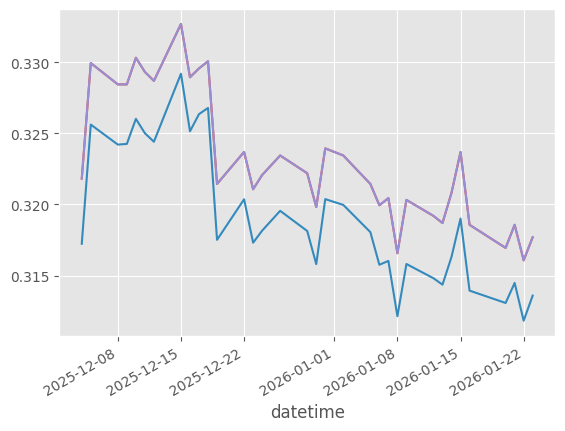

In [31]:
res.timeseries.plot()
crr_discrete.timeseries.plot()
bs_discrete.timeseries.plot()


In [32]:
# crr_vol = crr_discrete.timeseries
model_data = _load_model_data_timeseries(
    LoadRequest(
        symbol=symbol,
        start_date=ts_start,
        end_date=ts_end,
        expiration=expiration,
        strike=strike,
        right=right,
        div_type=DivType.DISCRETE,
        load_spot=True,
        load_forward=True,
        load_dividend=True,
        load_rates=True,
        load_option_spot=True,
        undo_adjust=True,
        endpoint_source=OptionSpotEndpointSource.QUOTE
    )
)
model_data

2026-01-24 23:42:05 [test] trade.optionlib.assets.dividend INFO: Using dual projection method for ticker AAPL
2026-01-24 23:42:05 [test] trade.optionlib.assets.dividend INFO: Expected Dividend Size before adjustment: 21, for original valuation: 13. Size from historical divs: 12
2026-01-24 23:42:05 [test] trade.optionlib.assets.dividend INFO: Expected Dividend Size to be projected: 9
2026-01-24 23:42:05 [test] trade.optionlib.assets.dividend INFO: Projected Dividend List: [0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26]
2026-01-24 23:42:05 [test] trade.optionlib.assets.dividend INFO: Combined Dividend List: [0.23, 0.24, 0.24, 0.24, 0.24, 0.25, 0.25, 0.25, 0.25, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26]
2026-01-24 23:42:05 [test] trade.optionlib.assets.dividend INFO: Combined Date List: [datetime.date(2023, 2, 10), datetime.date(2023, 5, 12), datetime.date(2023, 8, 11), datetime.date(2023, 11, 10), datetime.date(2024, 2, 9), datetime.date(2024, 5, 10),

ModelResultPack(series_id=<SeriesId.HIST: 'hist'>, dividend_type=<DivType.DISCRETE: 'discrete'>, undo_adjust=True, num_empty=1)

In [33]:
model_data.option_spot.daily_option_spot

,open,high,low,close,volume,bid_size,closebid,ask_size,closeask,midpoint,weighted_midpoint
datetime,,,,,,,,,,,
2025-12-04,0.0,109.500,0.0,106.200,0.0,274.0,104.50,10.0,107.90,106.200,104.619718
2025-12-05,0.0,107.750,0.0,105.250,0.0,153.0,103.00,262.0,107.50,105.250,105.840964
2025-12-08,0.0,105.500,0.0,104.300,0.0,311.0,102.60,22.0,106.00,104.300,102.824625
2025-12-09,0.0,106.300,0.0,103.700,0.0,400.0,101.50,399.0,105.90,103.700,103.697247
2025-12-10,0.0,105.975,0.0,105.100,0.0,392.0,102.70,388.0,107.50,105.100,105.087692
2025-12-11,0.0,105.000,0.0,104.250,0.0,436.0,102.00,433.0,106.50,104.250,104.242232
2025-12-12,0.0,105.550,0.0,104.250,0.0,153.0,102.00,154.0,106.50,104.250,104.257329
2025-12-15,0.0,103.475,0.0,101.025,0.0,17.0,99.85,134.0,102.20,101.025,101.935430
2025-12-16,0.0,101.925,0.0,101.075,0.0,15.0,100.10,74.0,102.05,101.075,101.721348


In [34]:
S, D, R, OPTION_MID, SIGMA, F = sync_date_index(
    model_data.spot.daily_spot,
    model_data.dividend.daily_discrete_dividends,
    model_data.rates.daily_risk_free_rates,
    model_data.option_spot.midpoint,
    crr_vol,
    model_data.forward.daily_discrete_forward,
)

european_equity_prices = vector_crr_binomial_pricing(
    S0=S.values,
    K=[strike] * len(S),
    T=[time_distance_helper(x, expiration) for x in S.index],
    r=R.values,
    dividends = vector_convert_to_time_frac(
        schedules=D,
        valuation_dates=S.index,
        end_dates=[to_datetime(expiration)] * len(S.index)
    ),
    right=[right.lower()] * len(S),
    american=[False] * len(S),
    N=[1000] * len(S),
    sigma=SIGMA.loc[S.index].values,
    dividend_type=[DivType.DISCRETE.name.lower()] * len(S)
)

eq_prices = pd.Series(data=european_equity_prices, index=S.index)

NameError: name 'crr_vol' is not defined

In [ ]:
bsm_eq_equiv_vols = vector_bsm_iv_estimation(
    F=F.values,
    K=[strike] * len(F),
    T=[time_distance_helper(x, expiration) for x in F.index],
    r=R.values,
    market_price=eq_prices.values,
    right=[right.lower()] * len(F),
)
bsm_vols = pd.Series(data=bsm_eq_equiv_vols, index=F.index)

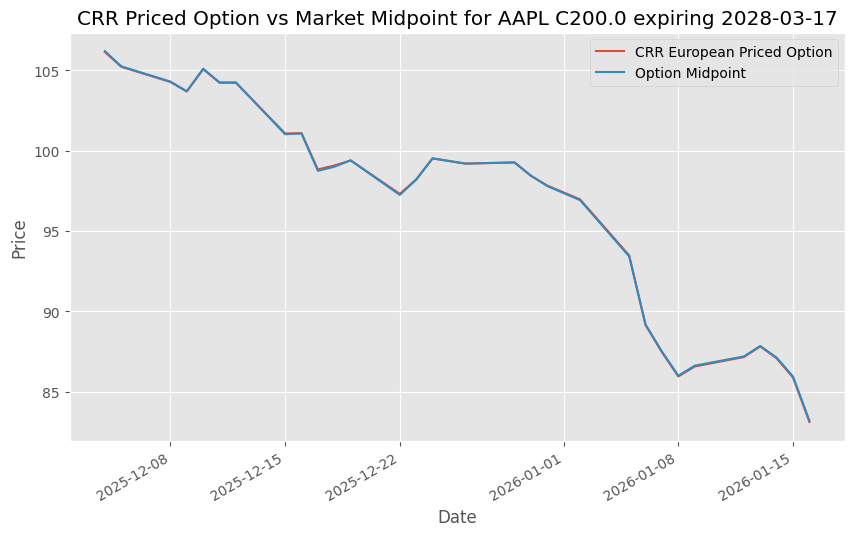

In [ ]:
import matplotlib.pyplot as plt
eq_prices.plot(label="CRR European Priced Option", figsize=(10, 6))
OPTION_MID.plot(label="Option Midpoint", figsize=(10, 6))

plt.title(f"CRR Priced Option vs Market Midpoint for {symbol} {right}{strike} expiring {expiration}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()

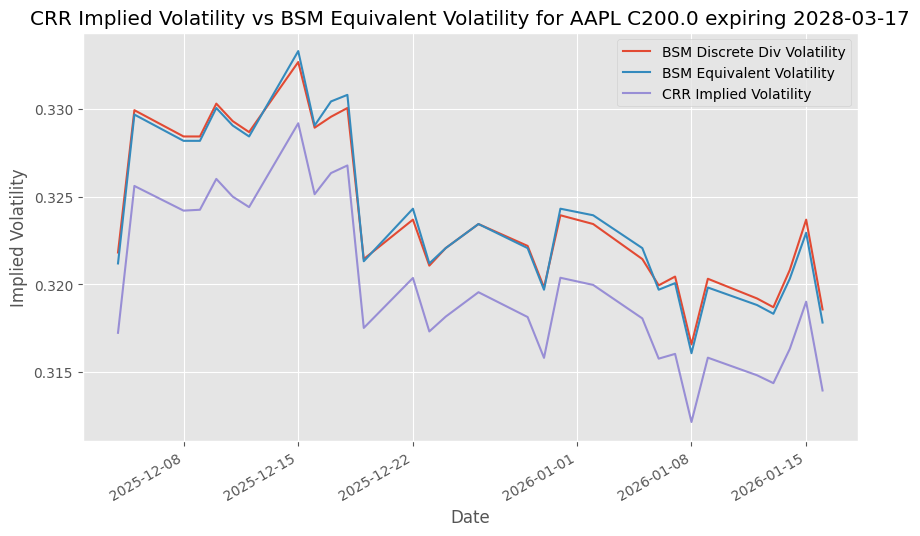

In [ ]:
bs_discrete_ts = bs_discrete.timeseries
bs_discrete_ts.plot(label="BSM Discrete Div Volatility", figsize=(10, 6))
bsm_vols.plot(label="BSM Equivalent Volatility", figsize=(10, 6))
crr_vol.plot(label="CRR Implied Volatility", figsize=(10, 6))
plt.title(f"CRR Implied Volatility vs BSM Equivalent Volatility for {symbol} {right}{strike} expiring {expiration}")
plt.xlabel("Date")
plt.ylabel("Implied Volatility")
plt.legend()

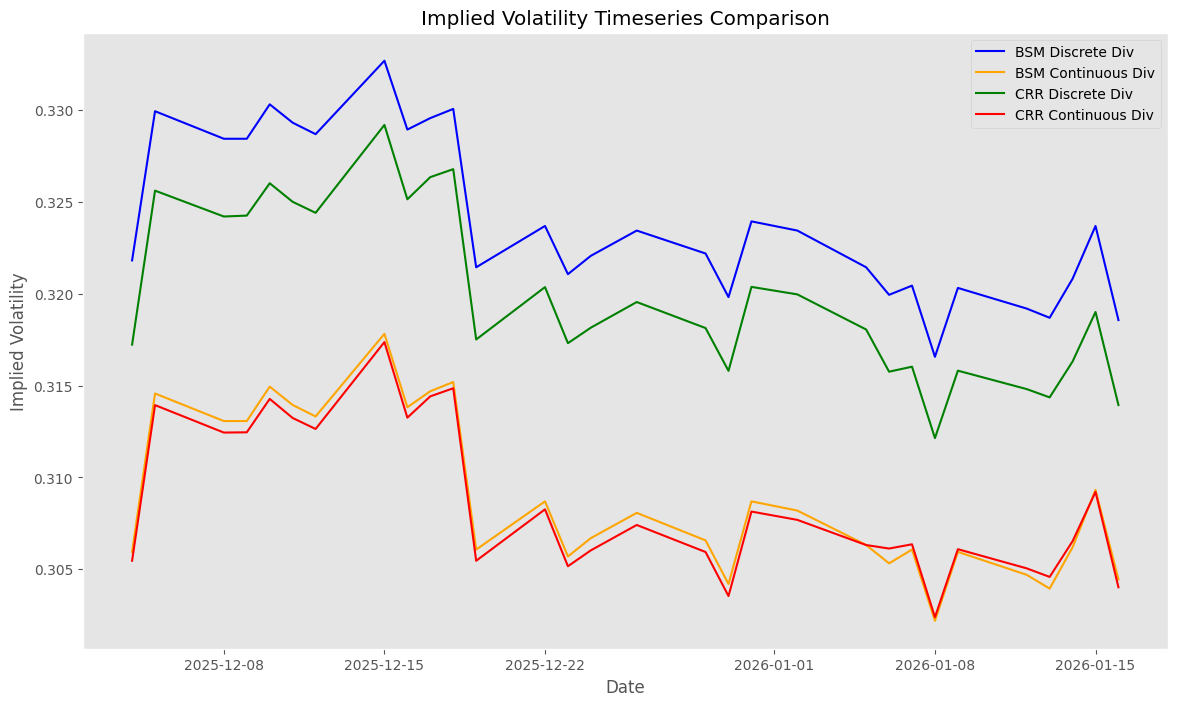

In [ ]:
bs_discrete_ts = bs_discrete.timeseries
bs_cont_ts = bs_cont.timeseries
crr_discrete_ts = crr_discrete.timeseries
crr_cont_ts = crr_cont.timeseries

import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8))
plt.plot(bs_discrete_ts.index, bs_discrete_ts.values, label="BSM Discrete Div", color="blue")
plt.plot(bs_cont_ts.index, bs_cont_ts.values, label="BSM Continuous Div", color="orange")
plt.plot(crr_discrete_ts.index, crr_discrete_ts.values, label="CRR Discrete Div", color="green")
plt.plot(crr_cont_ts.index, crr_cont_ts.values, label="CRR Continuous Div", color="red")
plt.title("Implied Volatility Timeseries Comparison")
plt.xlabel("Date")
plt.ylabel("Implied Volatility")
plt.legend()
plt.grid()
plt.show()

In [ ]:
bs_discrete_ts


datetime
2025-07-14    0.499913
2025-07-15    0.491289
2025-07-16    0.495288
2025-07-17    0.496413
2025-07-18    0.497163
                ...   
2026-01-12    0.537031
2026-01-13    0.542780
2026-01-14    0.547029
2026-01-15    0.552154
2026-01-16    0.555278
Length: 131, dtype: float64

In [ ]:
crr_binomial_pricing(
    K = strike,
    american = False,
    T = 0.5,
    sigma = 0.25,
    r = 0.03,
    S0 = 220.0,
    dividends = [(0.1, 5.0), (0.3, 5.0)],
    option_type = "c",
    dividend_type = "discrete",
    N = 200
)

17.053284342165583

In [ ]:
import matplotlib.pyplot as plt
discrete_vol.plot(label="Discrete Dividends IV")
cont_vol.plot(label="Continuous Dividends IV")
plt.legend()

NameError: name 'discrete_vol' is not defined

In [ ]:
DividendDataManager.INSTANCES['AAPL'].cache.keys()

['symbol:AAPL|interval:na|artifact_type:divs|series_id:hist|current_state:SCHEDULE|lookback_years:1|method:CONSTANT|vendor:YFINANCE',
 'symbol:COST|interval:na|artifact_type:divs|series_id:hist|current_state:SCHEDULE|lookback_years:1|method:CONSTANT|vendor:YFINANCE',
 'symbol:SBUX|interval:na|artifact_type:divs|series_id:hist|current_state:SCHEDULE|lookback_years:1|method:CONSTANT|vendor:YFINANCE',
 'symbol:AAPL|interval:eod|artifact_type:divs|series_id:hist|current_state:SCHEDULE_TIMESERIES|lookback_years:1|maturity:2028-03-17|method:CONSTANT|undo_adjust:1']

In [ ]:
vol_data.dividend.daily_discrete_dividends

datetime
2025-12-04    ((2026-02-10, 0.26), (2026-05-10, 0.26), (2026...
2025-12-05    ((2026-02-10, 0.26), (2026-05-10, 0.26), (2026...
2025-12-08    ((2026-02-10, 0.26), (2026-05-10, 0.26), (2026...
2025-12-09    ((2026-02-10, 0.26), (2026-05-10, 0.26), (2026...
2025-12-10    ((2026-02-10, 0.26), (2026-05-10, 0.26), (2026...
2025-12-11    ((2026-02-10, 0.26), (2026-05-10, 0.26), (2026...
2025-12-12    ((2026-02-10, 0.26), (2026-05-10, 0.26), (2026...
2025-12-15    ((2026-02-10, 0.26), (2026-05-10, 0.26), (2026...
2025-12-16    ((2026-02-10, 0.26), (2026-05-10, 0.26), (2026...
2025-12-17    ((2026-02-10, 0.26), (2026-05-10, 0.26), (2026...
2025-12-18    ((2026-02-10, 0.26), (2026-05-10, 0.26), (2026...
2025-12-19    ((2026-02-10, 0.26), (2026-05-10, 0.26), (2026...
2025-12-22    ((2026-02-10, 0.26), (2026-05-10, 0.26), (2026...
2025-12-23    ((2026-02-10, 0.26), (2026-05-10, 0.26), (2026...
2025-12-24    ((2026-02-10, 0.26), (2026-05-10, 0.26), (2026...
2025-12-26    ((2026-02-10, 0.2

In [ ]:
sync_date_index(vol_data.forward.daily_discrete_forward, 
                vol_data.rates.daily_risk_free_rates,
                vol_data.option_spot.daily_option_spot)

[datetime
 2026-01-14    278.430300
 2025-12-31    291.604396
 2025-12-16    294.998661
 2025-12-17    291.956677
 2025-12-09    298.578277
 2026-01-09    277.642885
 2026-01-15    276.542497
 2025-12-30    292.907049
 2025-12-11    299.005601
 2025-12-10    300.019099
 2026-01-12    278.633878
 2025-12-12    298.954905
 2025-12-15    294.439273
 2025-12-23    292.374288
 2025-12-04    302.413885
 2026-01-08    277.276901
 2025-12-18    292.168657
 2026-01-07    278.745903
 2026-01-05    286.286530
 2025-12-22    290.774190
 2025-12-24    293.967672
 2026-01-16    273.572360
 2026-01-02    290.538022
 2025-12-05    300.236797
 2025-12-19    293.741950
 2026-01-13    279.635458
 2025-12-26    293.387536
 2025-12-08    299.283696
 2026-01-06    280.996729
 2025-12-29    293.658153
 dtype: float64,
 datetime
 2026-01-14    0.03560
 2025-12-31    0.03547
 2025-12-16    0.03545
 2025-12-17    0.03543
 2025-12-09    0.03632
 2026-01-09    0.03513
 2026-01-15    0.03565
 2025-12-30    0.03540

In [ ]:

vol_data.time_to_load


{'date_range_packet': 0.00013685226440429688,
 'dividend_load_time': 5.028839826583862,
 'rates_load_time': 0.022665023803710938,
 'forward_load_time': 0.2790851593017578,
 'option_spot_load_time': 0.020485877990722656}

In [ ]:
dividends_ts = vol_data.dividend.daily_discrete_dividends
dividends_ts = vector_convert_to_time_frac(
    schedules=dividends_ts,
    valuation_dates=vol_data.option_spot.daily_option_spot.midpoint.index,
    end_dates=[to_datetime(expiration)] * len(vol_data.option_spot.daily_option_spot.midpoint.index)
)
dividends_ts

[<Schedule: 9 dividends>,
 <Schedule: 9 dividends>,
 <Schedule: 9 dividends>,
 <Schedule: 9 dividends>,
 <Schedule: 9 dividends>,
 <Schedule: 9 dividends>,
 <Schedule: 9 dividends>,
 <Schedule: 9 dividends>,
 <Schedule: 9 dividends>,
 <Schedule: 9 dividends>,
 <Schedule: 9 dividends>,
 <Schedule: 9 dividends>,
 <Schedule: 9 dividends>,
 <Schedule: 9 dividends>,
 <Schedule: 9 dividends>,
 <Schedule: 9 dividends>,
 <Schedule: 9 dividends>,
 <Schedule: 9 dividends>,
 <Schedule: 9 dividends>,
 <Schedule: 9 dividends>,
 <Schedule: 9 dividends>,
 <Schedule: 9 dividends>,
 <Schedule: 9 dividends>,
 <Schedule: 9 dividends>,
 <Schedule: 9 dividends>,
 <Schedule: 9 dividends>,
 <Schedule: 9 dividends>,
 <Schedule: 9 dividends>,
 <Schedule: 9 dividends>,
 <Schedule: 9 dividends>]

In [ ]:
DividendDataManager("AMD").cache.keys()

['symbol:AAPL|interval:na|artifact_type:divs|series_id:hist|current_state:SCHEDULE|lookback_years:1|method:CONSTANT|vendor:YFINANCE',
 'symbol:COST|interval:na|artifact_type:divs|series_id:hist|current_state:SCHEDULE|lookback_years:1|method:CONSTANT|vendor:YFINANCE',
 'symbol:SBUX|interval:na|artifact_type:divs|series_id:hist|current_state:SCHEDULE|lookback_years:1|method:CONSTANT|vendor:YFINANCE',
 'symbol:AAPL|interval:eod|artifact_type:divs|series_id:hist|current_state:SCHEDULE_TIMESERIES|lookback_years:1|maturity:2028-03-17|method:CONSTANT|undo_adjust:1',
 'symbol:AAPL|interval:eod|artifact_type:divs|series_id:hist|current_state:SCHEDULE_TIMESERIES|lookback_years:1|maturity:2026-07-17|method:CONSTANT|undo_adjust:1',
 'symbol:NVDA|interval:na|artifact_type:divs|series_id:hist|current_state:SCHEDULE|lookback_years:1|method:CONSTANT|vendor:YFINANCE',
 'symbol:NVDA|interval:eod|artifact_type:divs|series_id:hist|current_state:SCHEDULE_TIMESERIES|lookback_years:1|maturity:2026-07-17|meth

In [ ]:

v = vector_crr_iv_estimation(
    S0.tolist(),
    K,
    T,
    r.tolist(),
    market_price.tolist(),
    dividends_res,
    right,
    [100] * len(dividends.daily_discrete_dividends),
    dividend_type,
    [True] * len(dividends.daily_discrete_dividends)
)

Using non-batch processor for CRR implied volatility estimation.


In [ ]:
from trade.datamanager.utils.date import _sync_date

_sync_date(
    symbol="AAPL",
    start_date="2025-01-01",
    end_date="2026-01-18",
    strike=strike,
    expiration=expiration,
    right=right
)

(Timestamp('2025-12-04 00:00:00'), datetime.datetime(2026, 1, 18, 0, 0))

In [ ]:
import yfinance as yf
import pandas as pd
from trade.helpers.helper import to_datetime

start_date = "2023-01-01"
end_date = "2024-01-01"
interval = "1d"
start_date = to_datetime(start_date) - pd.Timedelta(days=5)
end_date = to_datetime(end_date) + pd.Timedelta(days=5)
def deannualize(annual_rate: float, periods: int = 365) -> float:
    """Converts annualized interest rate to per-period rate.

    Uses compound interest formula to convert annual rate to daily rate
    or other period-based rate.

    Args:
        annual_rate: Annualized interest rate (e.g., 0.05 for 5%).
        periods: Number of periods per year. Defaults to 365 for daily rate.

    Returns:
        Per-period interest rate (e.g., daily rate if periods=365).

    Examples:
        >>> # Convert 5% annual to daily rate
        >>> daily_rate = deannualize(0.05, periods=365)
        >>> print(f"{daily_rate:.6f}")
        0.000134

        >>> # Convert 5% annual to weekly rate
        >>> weekly_rate = deannualize(0.05, periods=52)
        >>> print(f"{weekly_rate:.6f}")
        0.000942
    """
    return (1 + annual_rate) ** (1 / periods) - 1
data_min = yf.download(
    "^IRX",
    start=start_date,
    end=end_date,
    interval=interval,
    progress=False,
    multi_level_index=False,
)

data_min.columns = data_min.columns.str.lower()
data_min["daily"] = (data_min["close"]/100).apply(deannualize)
data_min["annualized"] = data_min["close"] / 100
data_min["name"] = "^IRX"
data_min["description"] = "13 WEEK TREASURY BILL"
data_min.index.name = "Datetime"
data_min = data_min[["name", "description", "daily", "annualized"]]
data_min = data_min[
    (data_min.index >= pd.to_datetime(start_date)) & (data_min.index <= pd.to_datetime(end_date))
]


In [ ]:
data_min


,name,description,daily,annualized
Datetime,,,,
2022-12-27,^IRX,13 WEEK TREASURY BILL,0.000113,0.04195
2022-12-28,^IRX,13 WEEK TREASURY BILL,0.000116,0.04338
2022-12-29,^IRX,13 WEEK TREASURY BILL,0.000115,0.04295
2022-12-30,^IRX,13 WEEK TREASURY BILL,0.000114,0.04260
2023-01-03,^IRX,13 WEEK TREASURY BILL,0.000114,0.04255
...,...,...,...,...
2023-12-29,^IRX,13 WEEK TREASURY BILL,0.000138,0.05180
2024-01-02,^IRX,13 WEEK TREASURY BILL,0.000139,0.05213
2024-01-03,^IRX,13 WEEK TREASURY BILL,0.000140,0.05235
